In [165]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [166]:
df = pd.read_csv("C:\\Users\\kiril\\OneDrive\\Рабочий стол\\jupyter_projects\\insurance.csv")
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0}) 
df=pd.get_dummies(data=df,columns=['region'],drop_first=True,dtype=int)   
X=df.drop('charges',axis=1)
y = np.log1p(df['charges'])
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


(1338, 8)


In [167]:
class Node:
    def __init__(self,feature=None,threshold=None,left=None,right=None,value=None):
        self.feature=feature
        self.threshold=threshold
        self.left=left
        self.right=right
        self.value=value

class DecisionTree:
    def __init__(self, max_depth, min_samples_split, min_samples_leaf, max_features):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.tree = None
    
    def get_random_feature_indices(self, n_features):
        n_selected = int(n_features * self.max_features)
        indices = np.random.choice(n_features, size=n_selected, replace=False)
        return indices

    def choice_best_split(self, X, y):
        best_cost = 10**10
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        features = self.get_random_feature_indices(n_features)
        
        for feature in features:
            if len(np.unique(X[:, feature])) < 2:
                continue
                
            X_unique = np.sort(np.unique(X[:, feature]))
            thresholds = []
            for i in range(len(X_unique) - 1):
                threshold_value = (X_unique[i] + X_unique[i + 1]) / 2
                thresholds.append(threshold_value)

            for threshold in thresholds:
                left = []
                right = []
                for i in range(len(X)):
                    if X[i, feature] <= threshold:
                        left.append(y[i])
                    else:
                        right.append(y[i])
                        
                mse_left = np.var(left)
                mse_right = np.var(right)
                n_left = len(left)
                n_right = len(right)
                n = len(y)
                cost = (n_left / n) * mse_left + (n_right / n) * mse_right

                if cost < best_cost:
                    best_cost = cost
                    best_feature = feature
                    best_threshold = threshold

        if best_feature is None:
            return None, None, None
                    
        return best_feature, best_threshold, best_cost

    def build_tree(self, X, y, depth):
        n_samples = len(y)
        current_mse = np.var(y)

        if depth >= self.max_depth:
            return Node(value=np.mean(y))
        if n_samples < self.min_samples_split:
            return Node(value=np.mean(y))
        if current_mse == 0:
            return Node(value=np.mean(y))

        best_feature, best_threshold, best_cost = self.choice_best_split(X, y)

        if best_feature is None or best_threshold is None:
            return Node(value=np.mean(y))

        X_left, X_right = [], []
        y_left, y_right = [], []
        
        for i in range(len(X)):
            if X[i, best_feature] <= best_threshold:
                X_left.append(X[i])
                y_left.append(y[i])
            else:
                X_right.append(X[i])
                y_right.append(y[i])

        X_left = np.array(X_left)
        y_left = np.array(y_left)
        X_right = np.array(X_right)
        y_right = np.array(y_right)

        if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
            return Node(value=np.mean(y))

        left_child = self.build_tree(X_left, y_left, depth + 1)
        right_child = self.build_tree(X_right, y_right, depth + 1)

        return Node(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.tree = self.build_tree(X, y, depth=0)

    def predict_tree(self, X):
        X = np.array(X)
        predict = []
        for x in X:
            predict_value = self.predict_sample_tree(x, self.tree)
            predict.append(predict_value)
        return np.array(predict)

    def predict_sample_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.predict_sample_tree(x, node.left)
        else:
            return self.predict_sample_tree(x, node.right)

    def plot_tree_horizontal_tree(self, feature_names=None, max_depth_vis=4):

        fig, ax = plt.subplots(figsize=(14, 8))
        ax.axis('off')
        self.draw_horizontal_tree(ax, self.tree, x=0.0, y=0.5, level=0, 
                            max_level=max_depth_vis, feature_names=feature_names)
        plt.title("Дерево решений", fontsize=14)
        plt.tight_layout()

    def draw_horizontal_tree(self, ax, node, x, y, level, max_level, feature_names=None):
        if node is None or level > max_level:
            return

        x_step = 0.15  
        y_step = 0.2 / (2 ** level)  

        if node.value is not None:
            label = f"{node.value:.2f}"
            ax.text(x, y, label, ha="center", va="center",
                    bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="black", lw=1),
                    fontsize=9)
        else:
            feat = feature_names[node.feature] if feature_names else f"x[{node.feature}]"
            label = feat
            ax.text(x, y, label, ha="center", va="center",
                    bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="black", lw=1),
                    fontsize=9)

            next_x = x + x_step

            if node.left is not None:
                left_y = y - y_step
                ax.annotate("", xy=(next_x, left_y), xytext=(x, y),
                            arrowprops=dict(arrowstyle="-|>", color="gray", lw=0.8))
                ax.text((x + next_x) / 2, y - y_step / 2, f"≤{node.threshold:.2f}",
                        fontsize=7, ha="center", va="center", color="darkred")
                self.draw_horizontal_tree(ax, node.left, next_x, left_y, level + 1, max_level, feature_names)

            if node.right is not None:
                right_y = y + y_step
                ax.annotate("", xy=(next_x, right_y), xytext=(x, y),
                            arrowprops=dict(arrowstyle="-|>", color="gray", lw=0.8))
                ax.text((x + next_x) / 2, y + y_step / 2, f">{node.threshold:.2f}",
                        fontsize=7, ha="center", va="center", color="darkblue")
                self.draw_horizontal_tree(ax, node.right, next_x, right_y, level + 1, max_level, feature_names)

Train MSE: 0.12998789238792902
Test MSE:  0.1350050327912148
Test R2: 0.8498030260031539
Train R2:  0.8433826318314972


<Figure size 1920x1440 with 0 Axes>

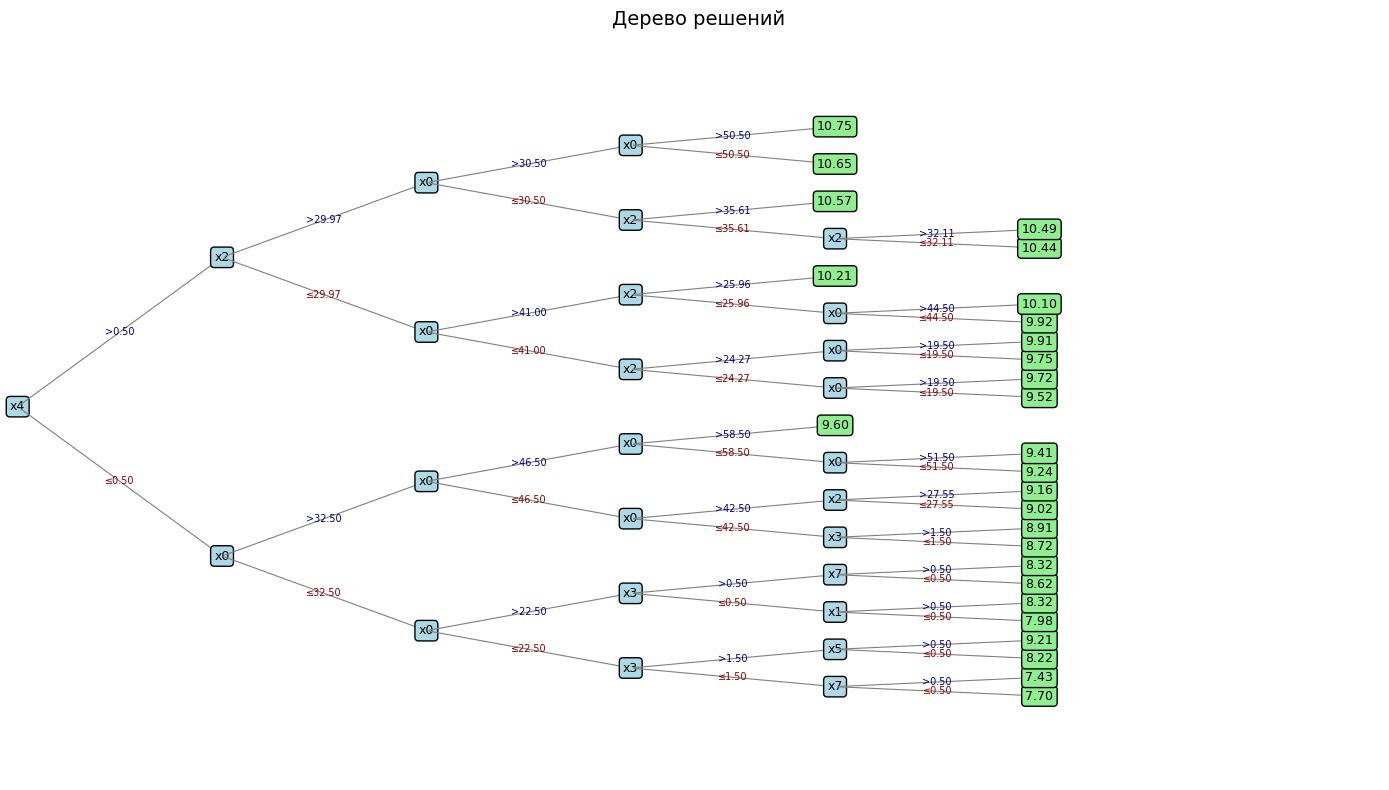

In [168]:
tree = DecisionTree(
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=4,
        max_features=1
    )
tree.fit(X_train, y_train)


y_pred_train = tree.predict_tree(X_train)
y_pred_test = tree.predict_tree(X_test)


mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test=r2_score(y_test,y_pred_test)
r2_train=r2_score(y_train,y_pred_train)


print(f"Train MSE: {mse_train}")
print(f"Test MSE:  {mse_test}")
print(f"Test R2: {r2_test}")
print(f"Train R2:  {r2_train}")
feature_names = [f"x{i}" for i in range(X_train.shape[1])]
plt.figure(dpi=300)
tree.plot_tree_horizontal_tree(feature_names=feature_names, max_depth_vis=7)

In [169]:
class GradientBoosting:
    def __init__(self, learning_rate=0.1, n_estimators=100, min_samples_split=4, max_depth=5, max_features=1):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features  
        self.zero_pred = None
        self.trees = []

    def fit_GB(self, X, y):
        self.zero_pred = y.mean()
        current_pred = np.full(len(y), self.zero_pred)
        for i in range(self.n_estimators):
            losses = y - current_pred
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=4,
                max_features=self.max_features  
            )
            tree.fit(X, losses)
            self.trees.append(tree)
            current_pred += self.learning_rate * tree.predict_tree(X)

    def predict_GB(self, X):
        predictions = np.full(X.shape[0], self.zero_pred)
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict_tree(X)
        return np.array(predictions)
    
    def plot_gb_trees(self, feature_names=None, max_depth_vis=None, n_trees=None):

        if n_trees is None:
            n_trees = len(self.trees)
        else:
            n_trees = min(n_trees, len(self.trees))
        
        if max_depth_vis is None:
            max_depth_vis = self.max_depth
            
        for i in range(n_trees):
            plt.figure(figsize=(14, 8))
            ax = plt.gca()
            ax.axis('off')
            
            plt.title(f"Дерево {i+1} из {len(self.trees)} ", fontsize=14, pad=20)
            
            self.trees[i].draw_horizontal_tree(ax, self.trees[i].tree, x=0.0, y=0.5, level=0, max_level=max_depth_vis, feature_names=feature_names)
            plt.tight_layout()
            plt.show()



Train MSE: 0.12998789238792902
Test MSE:  0.1350050327912148
Test R2: 0.8616995865821074
Train R2:  0.8684087678957761


<Figure size 1920x1440 with 0 Axes>

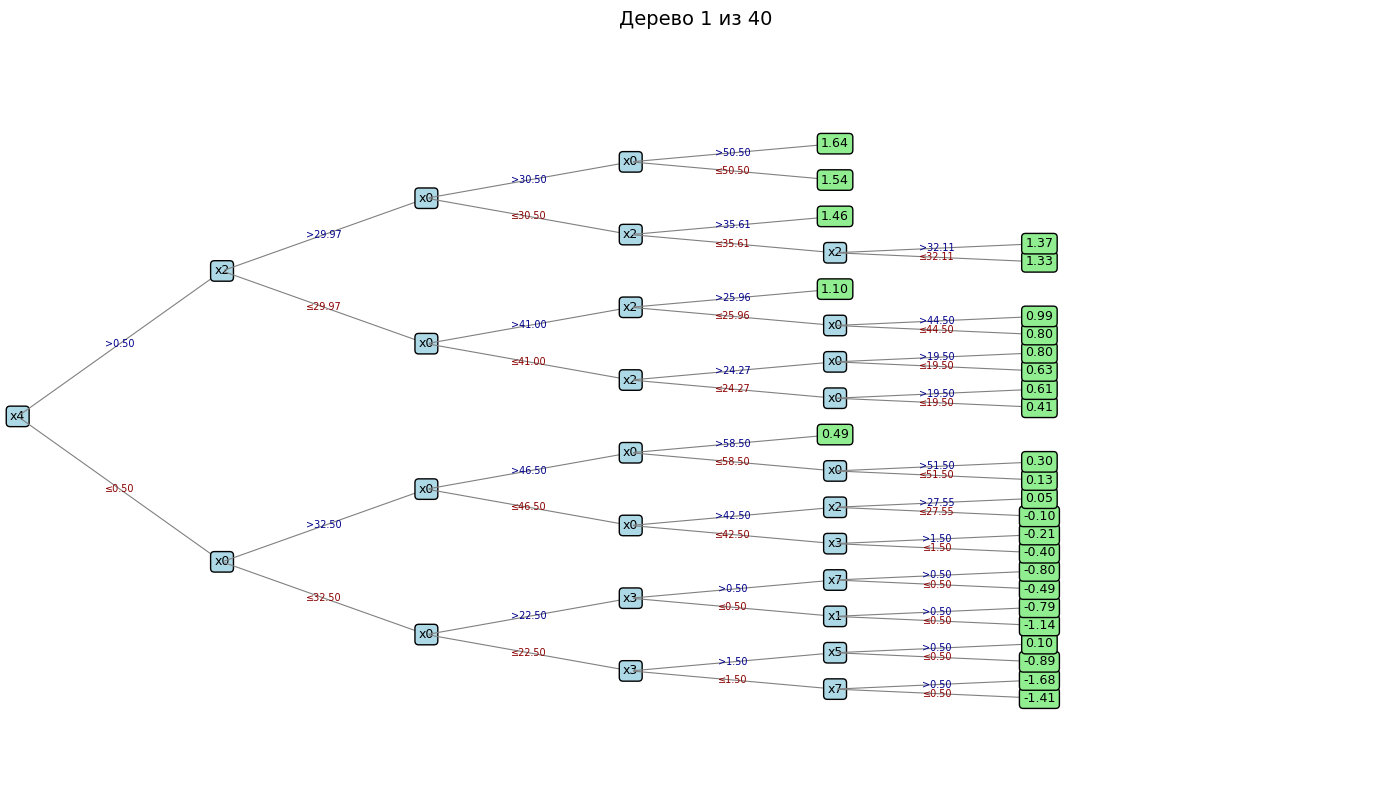

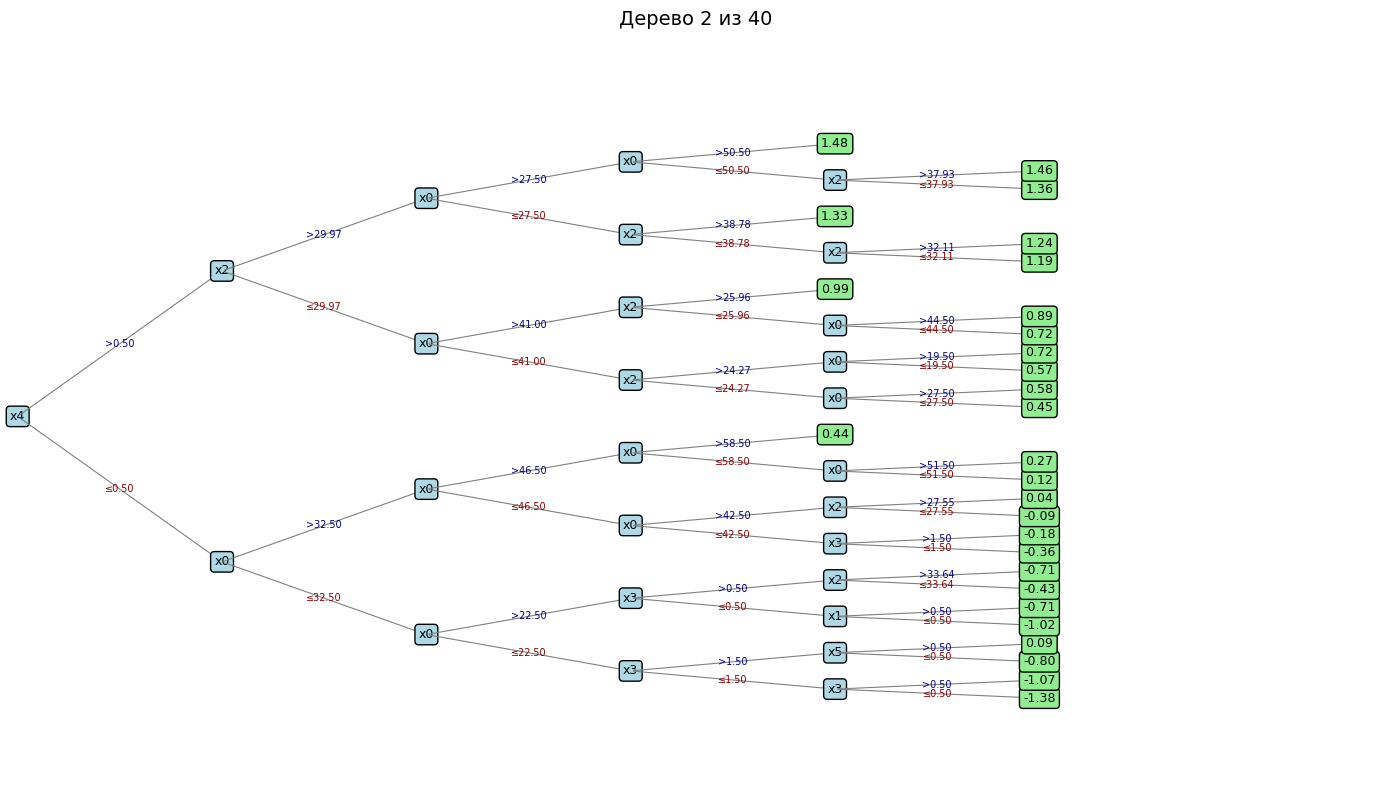

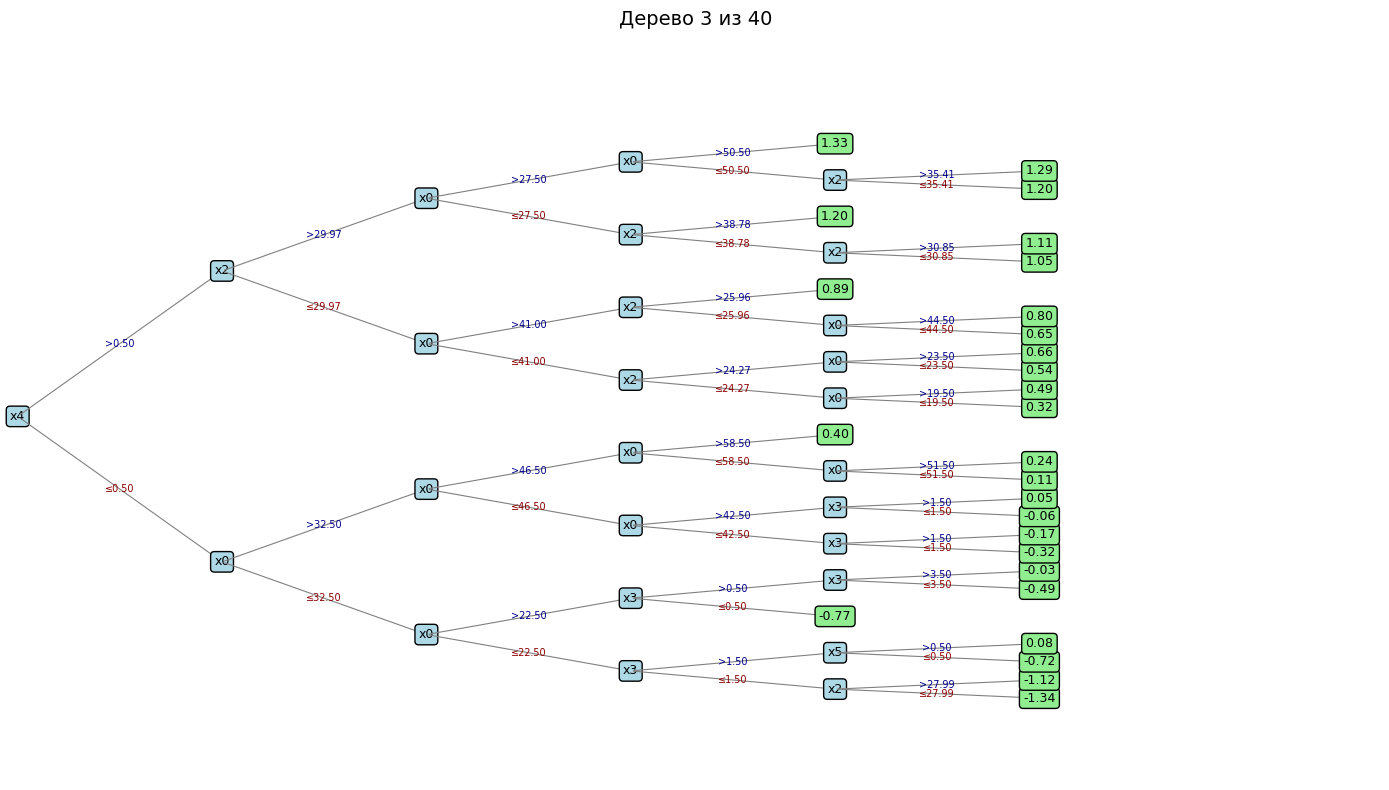

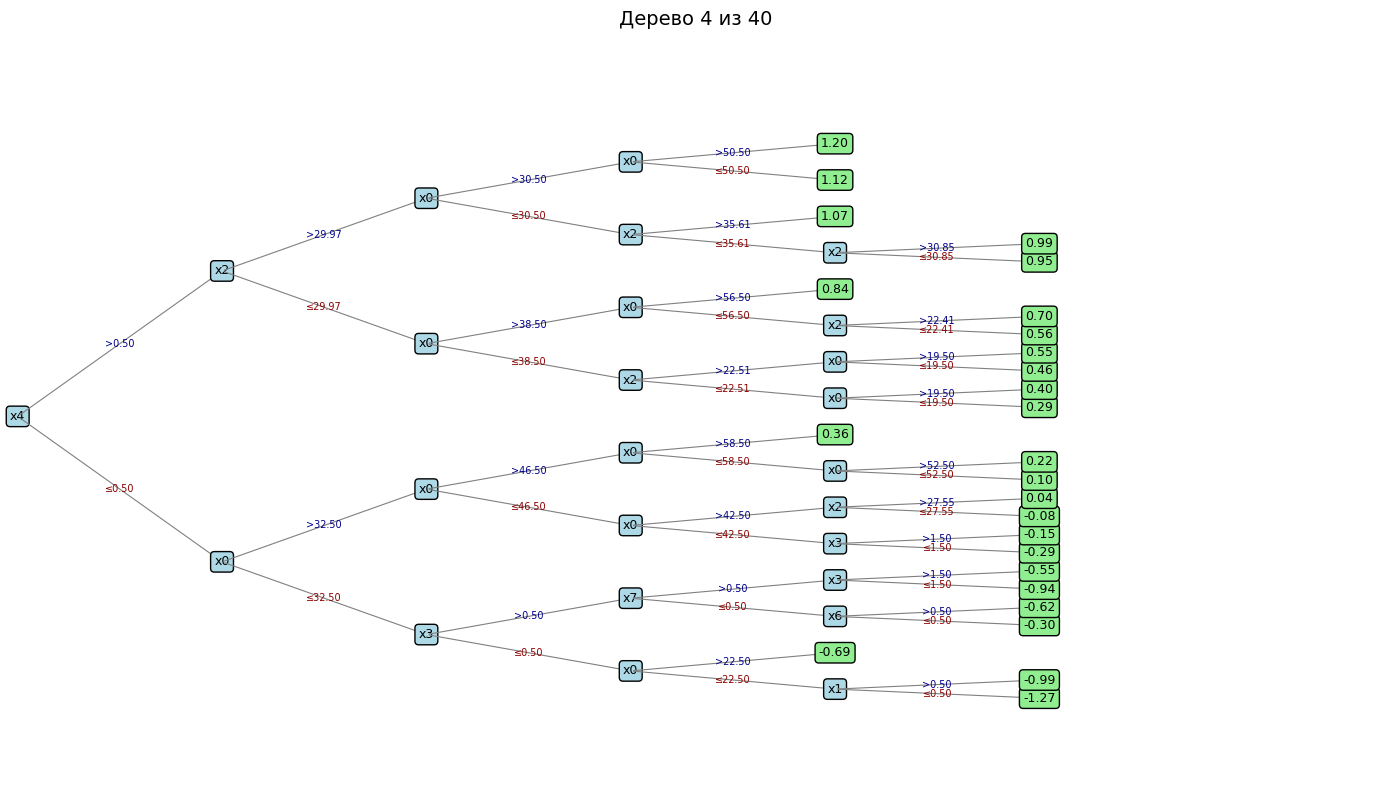

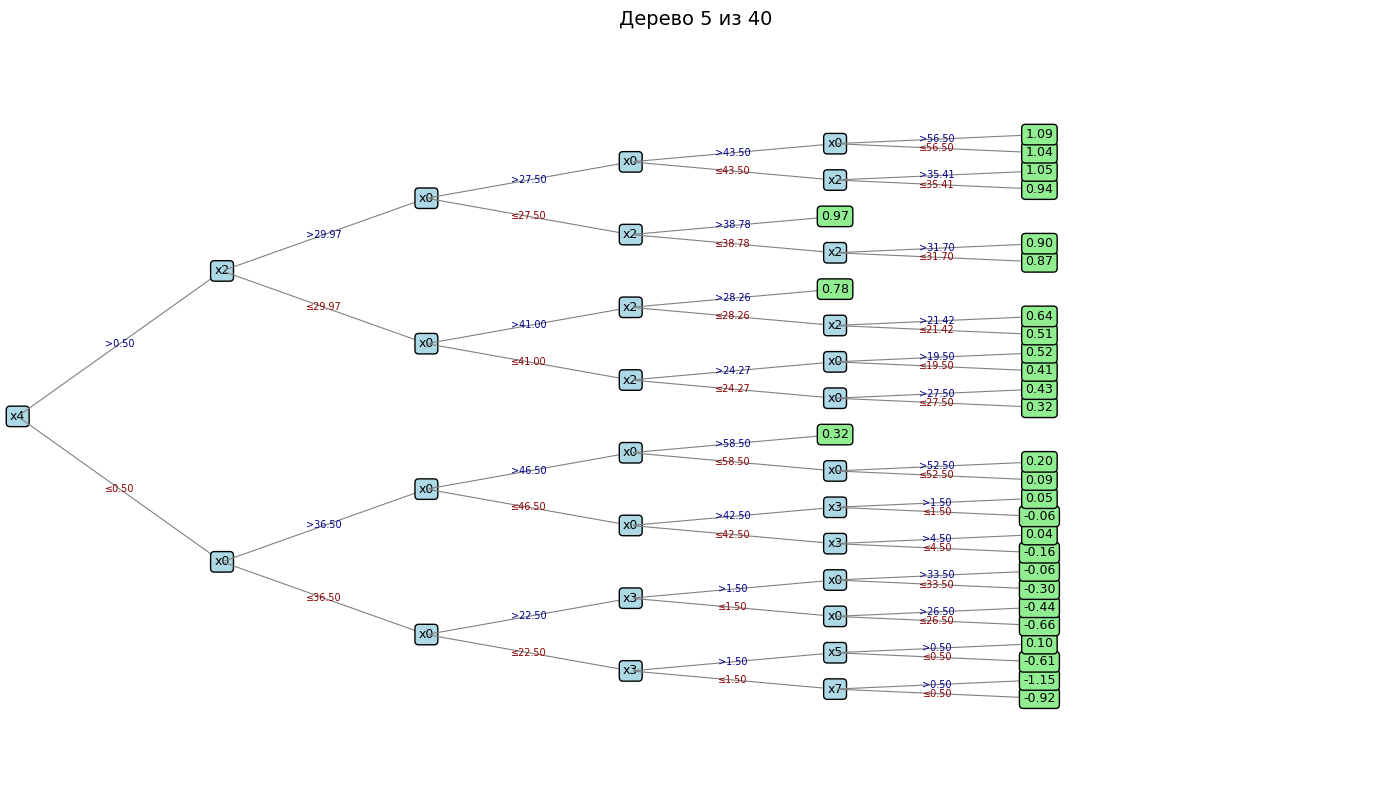

In [170]:
tree_GB=GradientBoosting(
    learning_rate=0.1,
    n_estimators=40,
    min_samples_split =4,
    max_depth=5,
    max_features=1)

tree_GB.fit_GB(X_train,y_train)

y_pred_train_GB = tree_GB.predict_GB(X_train)
y_pred_test_GB = tree_GB.predict_GB(X_test)


mse_train_GB = mean_squared_error(y_train, y_pred_train)
mse_test_GB = mean_squared_error(y_test, y_pred_test)
r2_test_GB=r2_score(y_test,y_pred_test_GB)
r2_train_GB=r2_score(y_train,y_pred_train_GB)


print(f"Train MSE: {mse_train_GB}")
print(f"Test MSE:  {mse_test_GB}")
print(f"Test R2: {r2_test_GB}")
print(f"Train R2:  {r2_train_GB}")
feature_names = [f"x{i}" for i in range(X_train.shape[1])]
plt.figure(dpi=300)

tree_GB.plot_gb_trees(feature_names=feature_names, n_trees=5, max_depth_vis=tree_GB.max_depth)

In [171]:
class RandomForest:
    def __init__(self, number_of_trees, min_samples_split=4, max_depth=5, max_features=0.9):
        self.number_of_trees = number_of_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def bootstrap(self, X, y):
        n_len = X.shape[0]
        indices = np.random.choice(a=n_len, size=n_len, replace=True)

        X_bootstrap = X[indices]
        y_bootstrap = y[indices]

        return X_bootstrap, y_bootstrap

    def fit_RF(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        for i in range(self.number_of_trees):
            X_bootstrap, y_bootstrap = self.bootstrap(X, y)
            
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=4,
                max_features=self.max_features  
            )
            tree.fit(X_bootstrap, y_bootstrap) 
            self.trees.append(tree)

    def predict(self, X): 
        X = np.array(X)
        
        all_predictions = []
        for tree in self.trees:
            tree_pred = tree.predict_tree(X)
            all_predictions.append(tree_pred)
        
        all_predictions = np.array(all_predictions)
        final_predictions = np.mean(all_predictions, axis=0)
        
        return final_predictions
    
    def plot_forest_trees(self, feature_names=None, max_depth_vis=None, n_trees=None):
        
        if n_trees is None:
            n_trees = len(self.trees)
        else:
            n_trees = min(n_trees, len(self.trees))
        
        if max_depth_vis is None:
            max_depth_vis = self.max_depth
            
        for i in range(n_trees):
            plt.figure(figsize=(14, 8))
            ax = plt.gca()
            ax.axis('off')
            plt.title(f"Дерево {i+1} из {len(self.trees)}", fontsize=14, pad=20)
            self.trees[i].draw_horizontal_tree(ax, self.trees[i].tree, x=0.0, y=0.5, level=0,max_level=max_depth_vis, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
  

Random Forest - Train MSE: 0.12349745655354652
Random Forest - Test MSE: 0.12534310165970225
Random Forest - Test R2: 0.860552201711021
Random Forest - Train R2: 0.8512027061474489


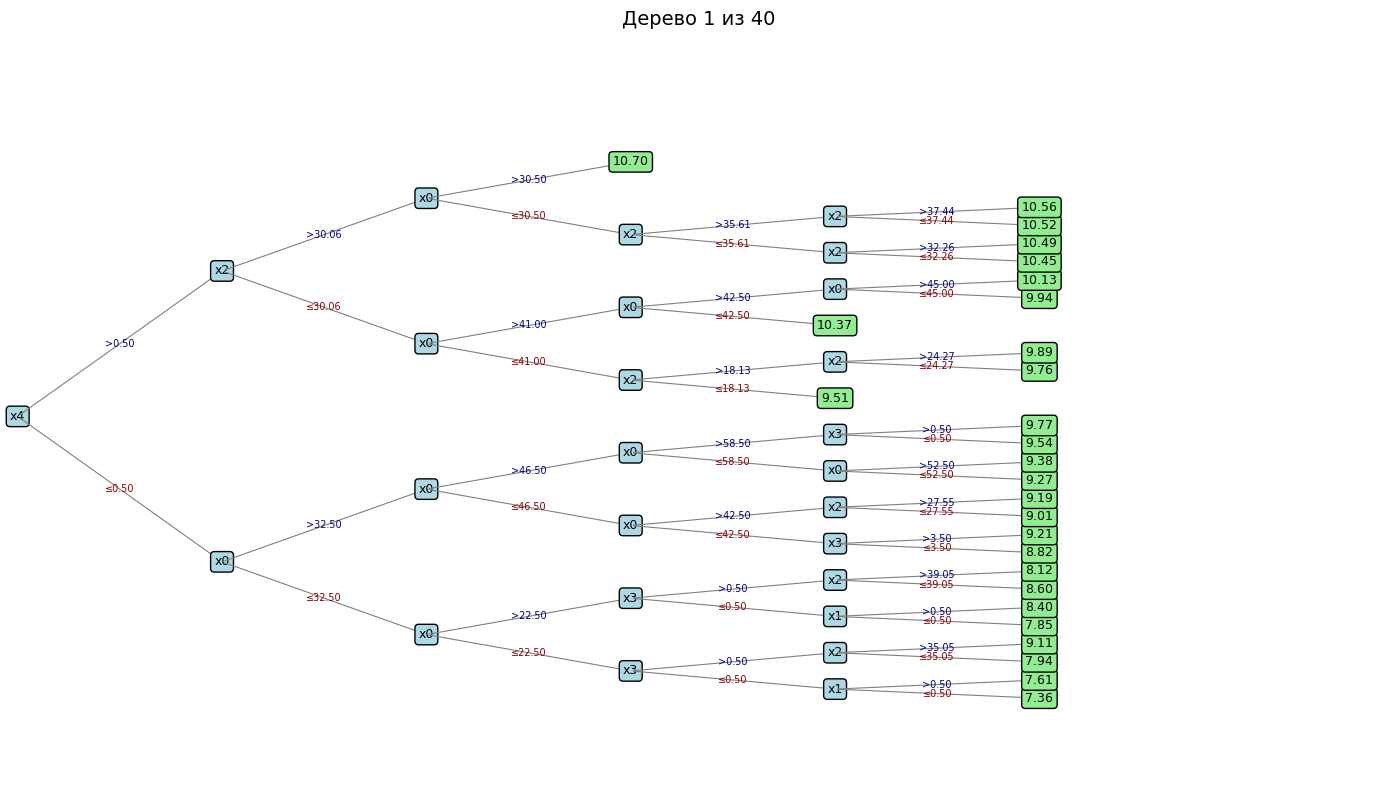

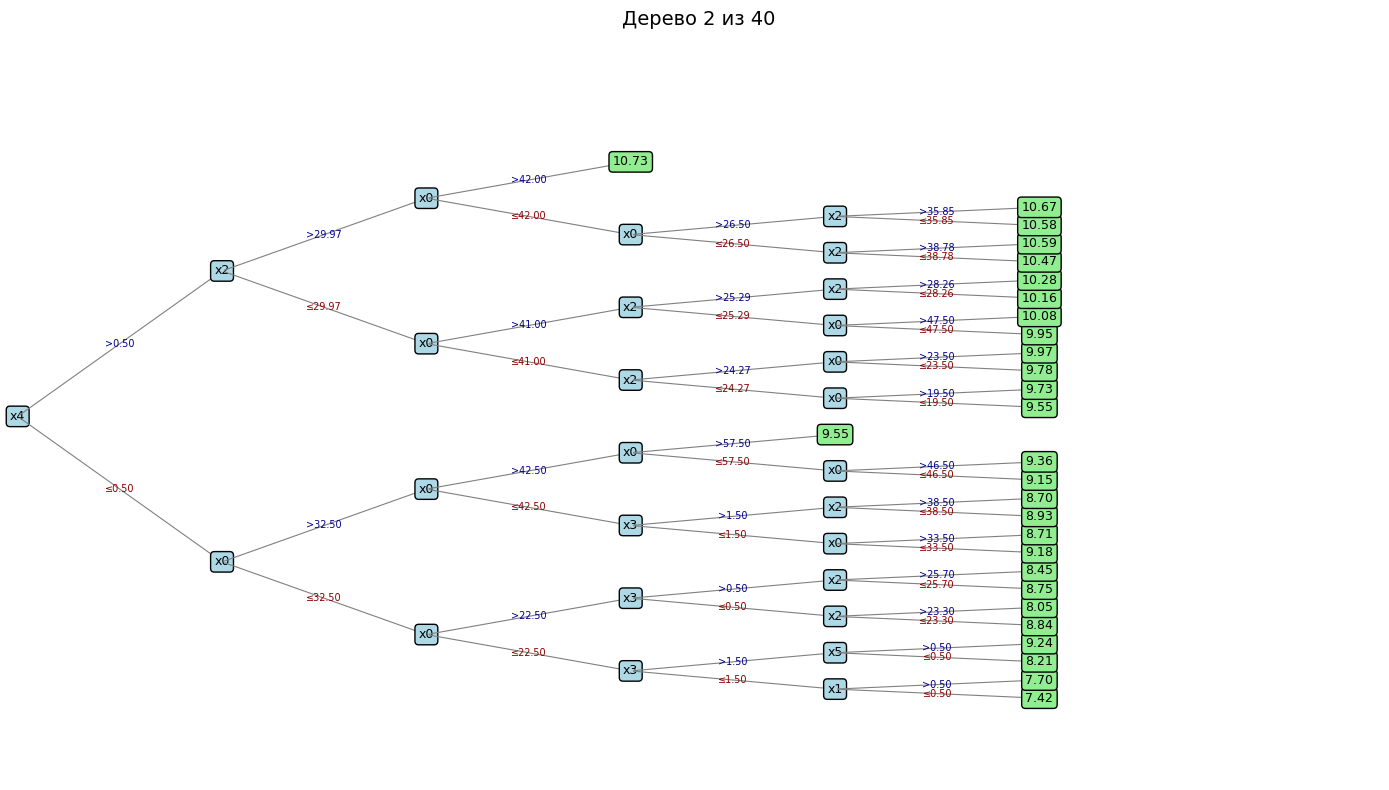

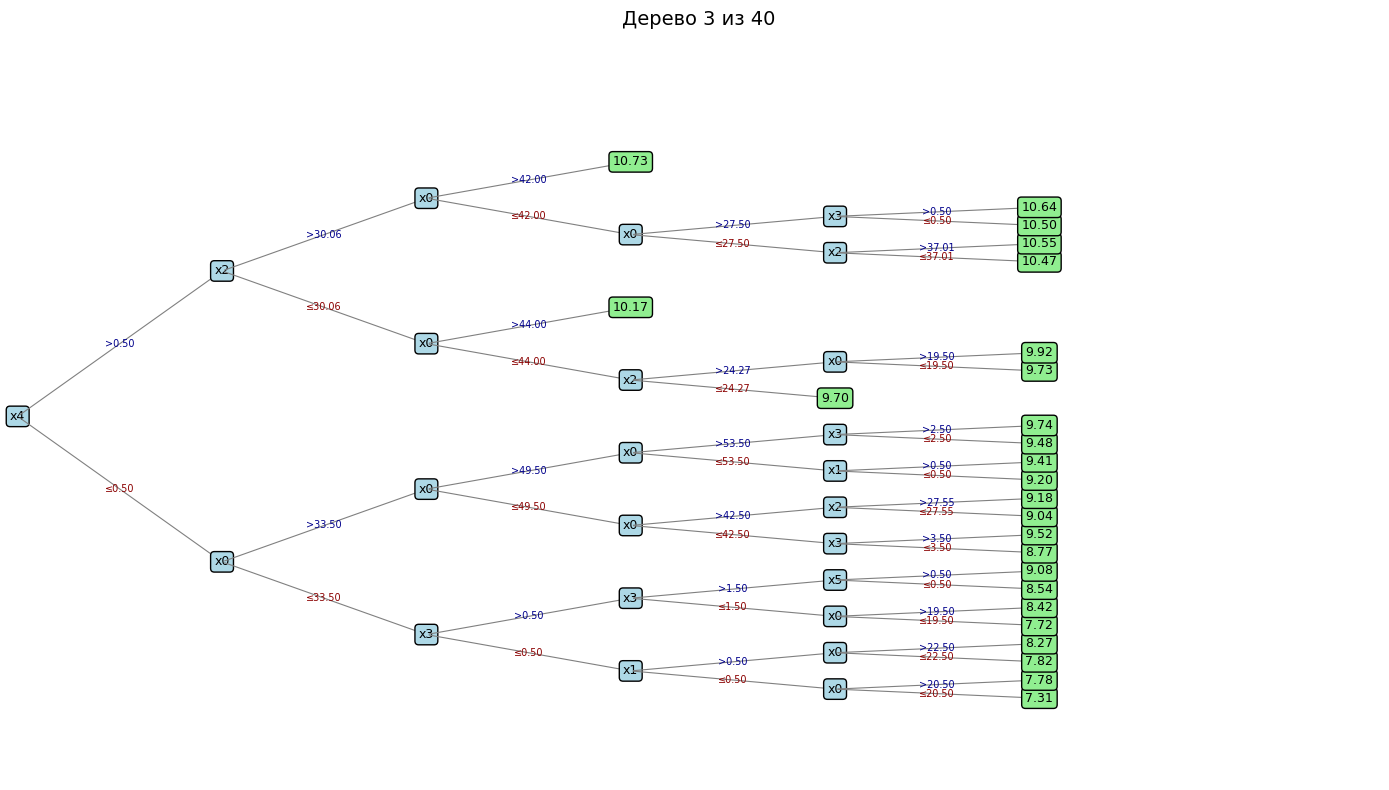

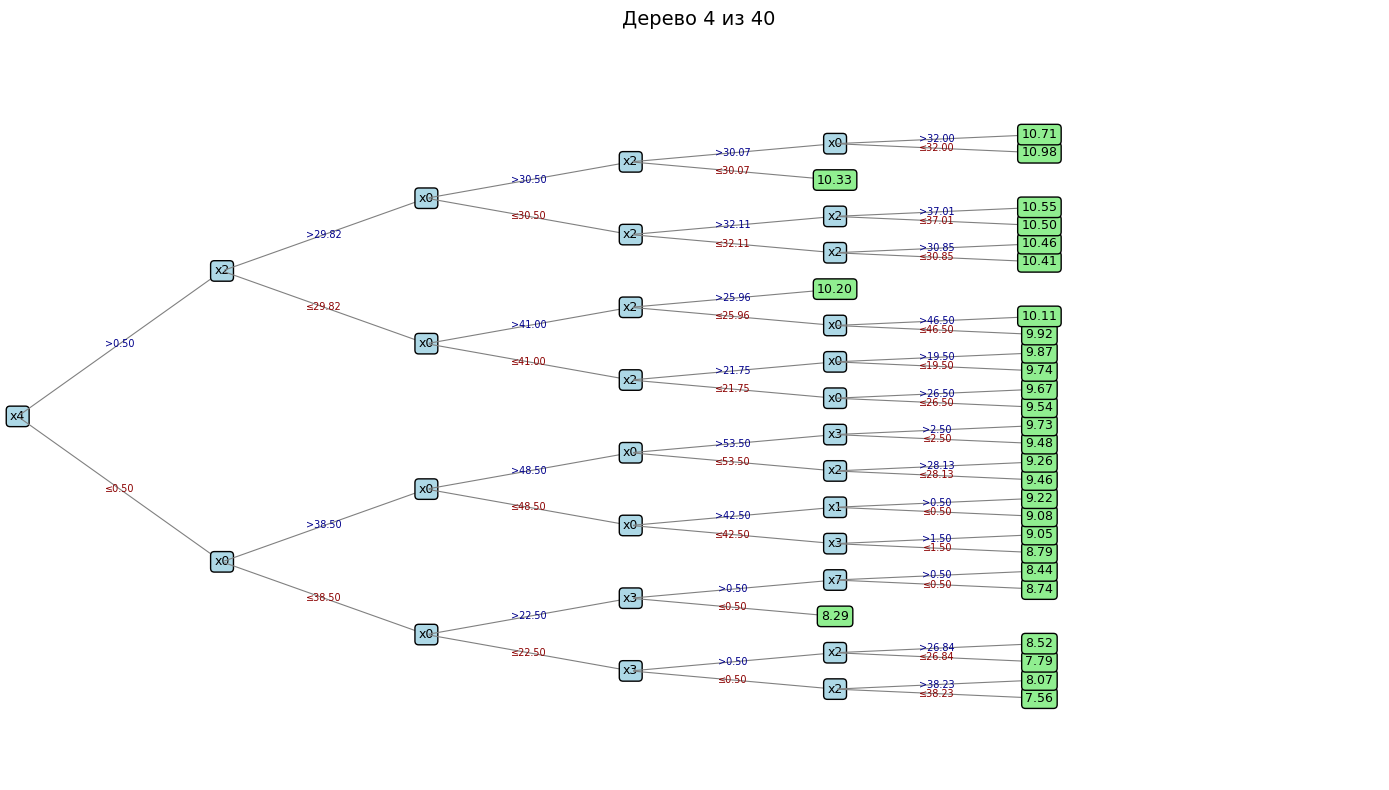

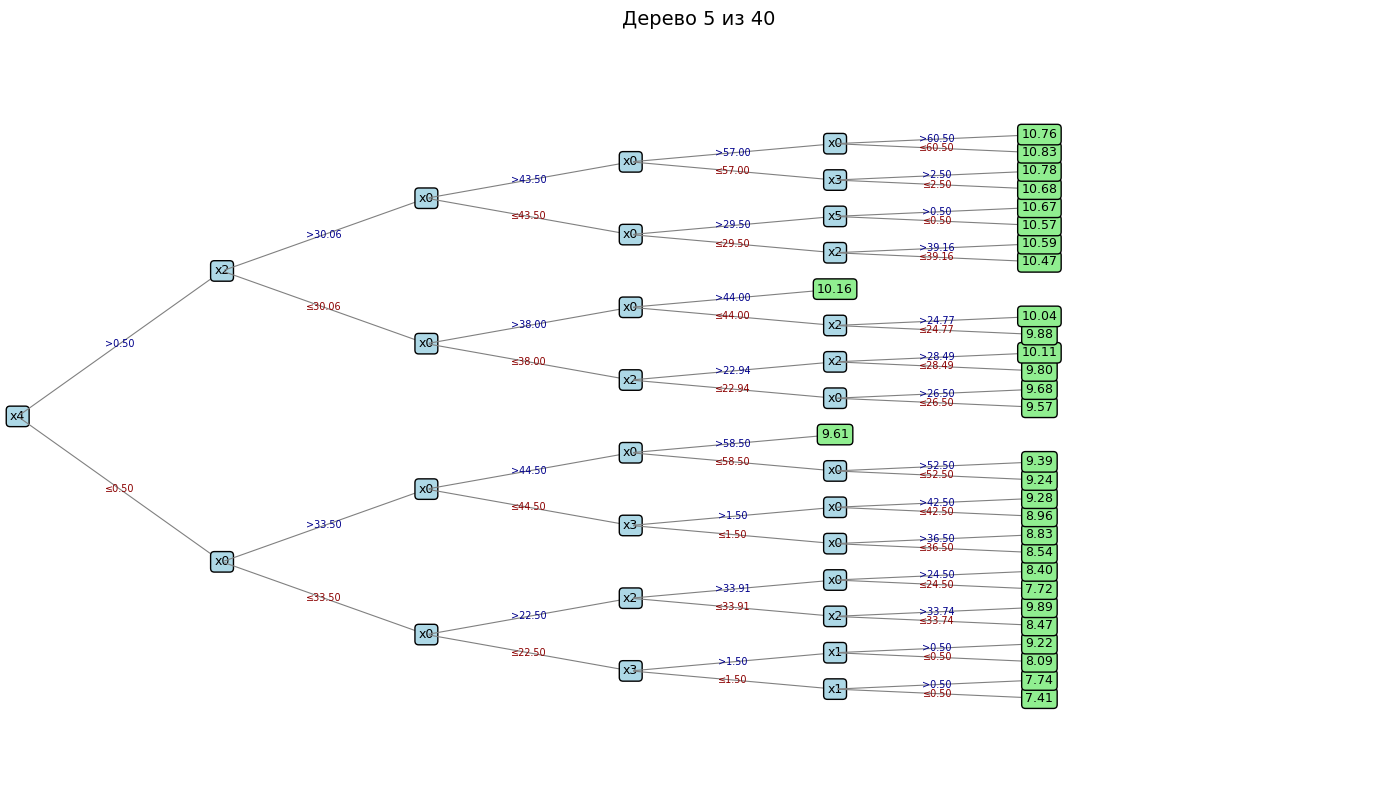

In [172]:
forest = RandomForest(
    number_of_trees=40,
    min_samples_split=4,
    max_depth=5,
    max_features=1
)

forest.fit_RF(X_train, y_train)


y_pred_train_forest = forest.predict(X_train)
y_pred_test_forest = forest.predict(X_test)

mse_train_forest = mean_squared_error(y_train, y_pred_train_forest)
mse_test_forest = mean_squared_error(y_test, y_pred_test_forest)
r2_test_forest = r2_score(y_test, y_pred_test_forest)
r2_train_forest = r2_score(y_train, y_pred_train_forest)

print(f"Random Forest - Train MSE: {mse_train_forest}")
print(f"Random Forest - Test MSE: {mse_test_forest}")
print(f"Random Forest - Test R2: {r2_test_forest}")
print(f"Random Forest - Train R2: {r2_train_forest}")


feature_names = [f"x{i}" for i in range(X_train.shape[1])]

forest.plot_forest_trees(feature_names=feature_names, n_trees=5)
